# Import dependencies and load the dataset

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, confusion_matrix, ConfusionMatrixDisplay
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
data = pd.read_csv('../data/CVD_cleaned.csv')
data

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,Very Good,Within the past year,Yes,No,No,No,No,No,No,Male,25-29,168.0,81.65,29.05,No,4.0,30.0,8.0,0.0
308850,Fair,Within the past 5 years,Yes,No,No,No,No,Yes,No,Male,65-69,180.0,69.85,21.48,No,8.0,15.0,60.0,4.0
308851,Very Good,5 or more years ago,Yes,No,No,No,Yes,"Yes, but female told only during pregnancy",No,Female,30-34,157.0,61.23,24.69,Yes,4.0,40.0,8.0,4.0
308852,Very Good,Within the past year,Yes,No,No,No,No,No,No,Male,65-69,183.0,79.38,23.73,No,3.0,30.0,12.0,0.0


# Artificially generate 3 datasets for different months to represent a real-life scenario

In [3]:
print(len(data)/3)
#data_jan = data[0:102951]
#data_feb = data[102951:2*102951]
#data_mar = data[2*102951:]
#data_jan.to_csv('../data/data_jan.csv', index=False)
#data_feb.to_csv('../data/data_feb.csv', index=False)
#data_mar.to_csv('../data/data_mar.csv', index=False)
data_jan = pd.read_csv("../data/data_jan.csv")
data_feb = pd.read_csv('../data/data_feb.csv')
data_mar = pd.read_csv('../data/data_mar.csv')

102951.33333333333


# Data preparation and analysis

We need to prepare the dataset in order to get it through our preprocessor. Since we would like to convert this analysis into a script, we will use functions as often as possible and we will be adding new responsibilities to the main prepare_features function along with the new discoveries. 

In [4]:
def prepare_features(data: pd.DataFrame, columns: list[str] = None):
    df = data.copy()
    
    if columns is None: 
        bin_columns = ["Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer", 
                       "Depression", "Arthritis", "Smoking_History"]
    else:
        bin_columns = columns
            
    df = transform_binaries(df, bin_columns)
    
    df = transform_diabetes(df) if "Diabetes" in df.columns else df
    
    return df

In [5]:
for column in ["Sex","Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer", "Depression", "Arthritis", "Smoking_History"]:
    display(data_jan[column].value_counts())

Female    53482
Male      49469
Name: Sex, dtype: int64

Yes    79842
No     23109
Name: Exercise, dtype: int64

No     94702
Yes     8249
Name: Heart_Disease, dtype: int64

No     92671
Yes    10280
Name: Skin_Cancer, dtype: int64

No     93135
Yes     9816
Name: Other_Cancer, dtype: int64

No     82993
Yes    19958
Name: Depression, dtype: int64

No     69833
Yes    33118
Name: Arthritis, dtype: int64

No     60591
Yes    42360
Name: Smoking_History, dtype: int64

In [6]:
def transform_binaries(data: pd.DataFrame, 
                       columns: list[str] = ["Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer",
                                             "Depression", "Arthritis", "Smoking_History"]):
    
    df = data.copy()
    for column in columns:
        df[column] = df[column].str.lower().map({'yes': 1, 'no':0})
    
    if "Sex" in df.columns:
        df["Sex"] = df["Sex"].map({"Female": 1, "Male": 0})
        
    return df

transform_binaries(data_jan)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,0,0,0,0,0,No,1,1,70-74,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,0,1,0,0,0,Yes,0,1,70-74,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,1,0,0,0,0,Yes,0,1,60-64,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,Poor,Within the past year,1,1,0,0,0,Yes,0,0,75-79,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,Good,Within the past year,0,0,0,0,0,No,0,0,80+,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102946,Very Good,Within the past year,1,1,0,0,1,No,1,0,70-74,178.0,92.99,29.41,1,4.0,60.0,4.0,0.0
102947,Excellent,Within the past 2 years,1,0,0,0,0,No,0,0,55-59,183.0,90.72,27.12,1,30.0,90.0,4.0,2.0
102948,Good,Within the past year,1,0,0,0,1,No,1,1,55-59,173.0,106.59,35.73,0,4.0,16.0,0.0,5.0
102949,Good,Within the past year,0,0,1,0,0,No,0,0,70-74,183.0,77.11,23.06,1,0.0,3.0,5.0,1.0


Now, let us try to see what difference does it make to have diabetes only during pregnancy with respect to not having at all.

In [7]:
transform_binaries(data_jan).groupby(by='Diabetes').Heart_Disease.mean()

Diabetes
No                                            0.060450
No, pre-diabetes or borderline diabetes       0.102522
Yes                                           0.207498
Yes, but female told only during pregnancy    0.044444
Name: Heart_Disease, dtype: float64

Let us also check if these means are representative in amount of cases.

In [8]:
for df in [data_jan,data_feb,data_mar]:
    display(transform_binaries(df).groupby(by='Diabetes').Heart_Disease.mean())

Diabetes
No                                            0.060450
No, pre-diabetes or borderline diabetes       0.102522
Yes                                           0.207498
Yes, but female told only during pregnancy    0.044444
Name: Heart_Disease, dtype: float64

Diabetes
No                                            0.059873
No, pre-diabetes or borderline diabetes       0.124260
Yes                                           0.201091
Yes, but female told only during pregnancy    0.037585
Name: Heart_Disease, dtype: float64

Diabetes
No                                            0.061496
No, pre-diabetes or borderline diabetes       0.119737
Yes                                           0.216563
Yes, but female told only during pregnancy    0.027382
Name: Heart_Disease, dtype: float64

According to these statistics seems reasonable to apply the same weight to No, as only during pregnancy and even more, to assign half the weight to pre-diabetes than to diabetes.

In [9]:
def transform_diabetes(data: pd.DataFrame):
    df = data.copy()
    df['Diabetes'] = df['Diabetes'].str.lower().map({"yes": 1,
                                         "yes, but female told only during pregnancy": 0, 
                                         "no": 0, 
                                         "no, pre-diabetes or borderline diabetes": 0.5})
    return df

transform_diabetes(data_jan)["Diabetes"].value_counts()

0.0    87356
1.0    13176
0.5     2419
Name: Diabetes, dtype: int64

In [10]:
data_jan['General_Health'].unique()

array(['Poor', 'Very Good', 'Good', 'Fair', 'Excellent'], dtype=object)

In [11]:
data_jan['Checkup'].unique()

array(['Within the past 2 years', 'Within the past year',
       '5 or more years ago', 'Within the past 5 years', 'Never'],
      dtype=object)

In [12]:
print(np.sort(data_jan['Age_Category'].unique()))

['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']


In [13]:
ct = ColumnTransformer(
    [
        ("gen_health_preprocess", 
         OrdinalEncoder(categories=[["Poor","Fair","Good","Very Good","Excellent"]]),
         ["General_Health"]),
        
        
        ("checkup_preprocess",
         OrdinalEncoder(categories=[['Never','5 or more years ago','Within the past 5 years',
                                    'Within the past 2 years', 'Within the past year']]),
         ["Checkup"]),
        
        
        ("age_preprocess",
         OrdinalEncoder(categories=[['18-24','25-29','30-34','35-39','40-44','45-49','50-54',
                                     '55-59','60-64','65-69','70-74','75-79','80+']],
                       handle_unknown='use_encoded_value', unknown_value=-1),
         ["Age_Category"]),
        
        
        ("num_preprocess", 
         StandardScaler(),
         ["Height_(cm)","Weight_(kg)","BMI","Alcohol_Consumption","Fruit_Consumption",
          "Green_Vegetables_Consumption","FriedPotato_Consumption"])
    ],
    remainder = 'passthrough'
)

transformer_columns = ["General_Health","Checkup","Age_Category","Height_(cm)",
                       "Weight_(kg)","BMI","Alcohol_Consumption","Fruit_Consumption",
                       "Green_Vegetables_Consumption","FriedPotato_Consumption"]
remainder_columns = []
for col in prepare_features(data_jan).drop(columns = ["Heart_Disease"]).columns:
    if col not in transformer_columns:
        remainder_columns.append(col)
column_transformer_order = np.concatenate((transformer_columns,remainder_columns))
column_transformer_order

array(['General_Health', 'Checkup', 'Age_Category', 'Height_(cm)',
       'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption',
       'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression',
       'Diabetes', 'Arthritis', 'Sex', 'Smoking_History'], dtype='<U28')

Before applying the column transformer for visualization, we will split into train, validation and test to avoid data leakage. Given that we have a bit under 8% of population with Heart Disease, we will use the stratify method. Another possibility would be to use different months as train, validation and test. We'll do this in production.

In [14]:
print(data_jan.Heart_Disease.value_counts(normalize=True))
X = prepare_features(data_jan).drop(columns=["Heart_Disease"])
y = prepare_features(data_jan)["Heart_Disease"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify = y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, train_size=0.5)
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

No     0.919875
Yes    0.080125
Name: Heart_Disease, dtype: float64
0    75761
1     6599
Name: Heart_Disease, dtype: int64
0    9470
1     825
Name: Heart_Disease, dtype: int64
0    9471
1     825
Name: Heart_Disease, dtype: int64


In [15]:
X_train

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
94539,Excellent,Within the past year,1,0,0,0,0.0,0,1,50-54,163.0,67.59,25.58,0,2.0,90.0,12.0,1.0
74484,Very Good,Within the past year,1,0,0,0,0.0,0,1,75-79,157.0,59.87,24.14,1,0.0,28.0,12.0,4.0
98852,Very Good,Within the past year,0,0,0,0,0.0,0,1,50-54,168.0,62.60,22.27,0,8.0,30.0,30.0,4.0
79688,Good,Within the past year,1,0,0,1,0.0,0,0,25-29,180.0,117.93,36.26,0,4.0,4.0,0.0,16.0
31754,Good,Within the past year,0,0,0,0,0.0,0,1,55-59,170.0,81.65,28.19,1,30.0,30.0,15.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93501,Good,Within the past year,0,0,0,0,1.0,1,1,75-79,157.0,113.40,45.73,0,0.0,28.0,8.0,1.0
58019,Poor,Within the past year,1,1,1,0,0.0,1,1,80+,168.0,58.97,20.98,1,30.0,60.0,4.0,0.0
8950,Excellent,Within the past year,1,0,0,0,0.0,1,0,50-54,175.0,87.09,28.35,0,10.0,10.0,15.0,11.0
52633,Excellent,Within the past year,1,0,0,0,0.0,0,1,25-29,157.0,74.84,30.18,1,12.0,30.0,30.0,5.0


In [16]:
X_trans = pd.DataFrame(data = ct.fit_transform(X_train), index = X_train.index, columns = column_transformer_order)
X_val = pd.DataFrame(data = ct.transform(X_val), index = X_val.index, columns = column_transformer_order)
X_test = pd.DataFrame(data = ct.transform(X_test), index = X_test.index, columns = column_transformer_order)
X_trans

,General_Health,Checkup,Age_Category,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Smoking_History
94539,4.0,4.0,6.0,-0.712456,-0.733048,-0.448843,-0.385463,2.449877,-0.211387,-0.618009,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
74484,3.0,4.0,11.0,-1.273586,-1.093772,-0.668990,-0.625364,-0.061696,-0.211387,-0.269187,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
98852,3.0,4.0,6.0,-0.244847,-0.966210,-0.954875,0.334241,0.019322,0.993802,-0.269187,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
79688,2.0,4.0,1.0,0.877413,1.619129,1.183911,-0.145562,-1.033918,-1.014847,1.126103,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31754,2.0,4.0,7.0,-0.057804,-0.076084,-0.049827,2.973153,0.019322,-0.010522,0.428458,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93501,2.0,4.0,11.0,-1.273586,1.407461,2.631682,-0.625364,-0.061696,-0.479207,-0.618009,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
58019,0.0,4.0,12.0,-0.244847,-1.135825,-1.152090,2.973153,1.234599,-0.747027,-0.734284,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
8950,4.0,4.0,6.0,0.409805,0.178105,-0.025367,0.574142,-0.790863,-0.010522,0.544732,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52633,4.0,4.0,1.0,-1.273586,-0.394286,0.254403,0.814043,0.019322,0.993802,-0.152913,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


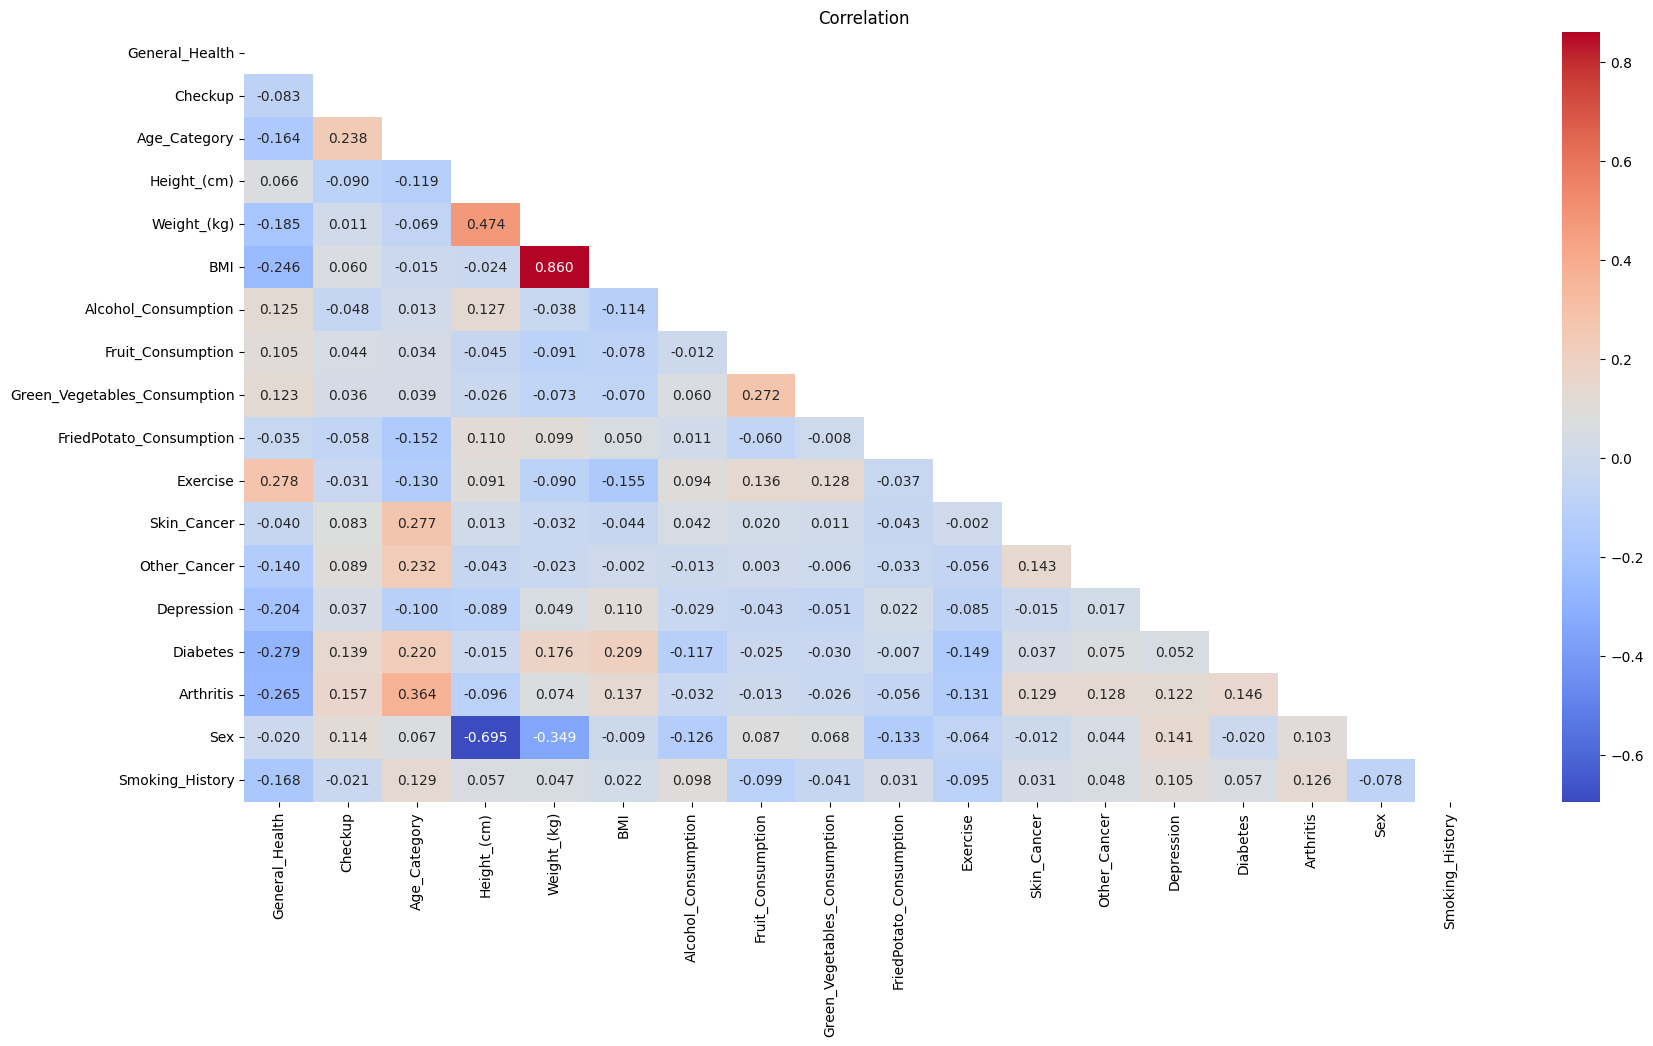

In [24]:
correlation_matrix = X_trans.corr()

correlation_matrix_rounded = correlation_matrix.round(3)

lower_triangle_mask = np.triu(np.ones(correlation_matrix.shape)).astype(bool)
cor_mat_lower = correlation_matrix.mask(lower_triangle_mask)
plt.figure(figsize=(20, 10))
sns.heatmap(cor_mat_lower, annot=True, cmap='coolwarm', fmt=".3f")  # Define o formato para quatro casas decimais
plt.title('Correlation')
plt.show()

In [19]:
rf = RandomForestClassifier()

rf.fit(X_trans, y_train)
importances_series = pd.Series(rf.feature_importances_, index=X_trans.columns).sort_values(ascending = False)


In [20]:
importances_series

BMI                             0.142492
Weight_(kg)                     0.121831
Age_Category                    0.093770
Height_(cm)                     0.089692
Green_Vegetables_Consumption    0.089672
Fruit_Consumption               0.088231
FriedPotato_Consumption         0.086293
General_Health                  0.064783
Alcohol_Consumption             0.059441
Diabetes                        0.026573
Arthritis                       0.019830
Depression                      0.018333
Smoking_History                 0.017599
Exercise                        0.017382
Checkup                         0.016801
Other_Cancer                    0.016301
Sex                             0.015815
Skin_Cancer                     0.015159
dtype: float64

In [21]:
print(classification_report(y_train,rf.predict(X_trans)))
print(classification_report(y_val,rf.predict(X_val)))
print(classification_report(y_test,rf.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75761
           1       1.00      1.00      1.00      6599

    accuracy                           1.00     82360
   macro avg       1.00      1.00      1.00     82360
weighted avg       1.00      1.00      1.00     82360

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9470
           1       0.43      0.03      0.05       825

    accuracy                           0.92     10295
   macro avg       0.68      0.51      0.50     10295
weighted avg       0.88      0.92      0.88     10295

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9471
           1       0.47      0.04      0.07       825

    accuracy                           0.92     10296
   macro avg       0.70      0.52      0.52     10296
weighted avg       0.89      0.92      0.89     10296



In [22]:
pd.Series(rf.predict(X_val)).value_counts()

0    10246
1       49
dtype: int64

In [23]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y_pred=rf.predict(X_val), y_true=y_val))
print(precision_score(y_pred=rf.predict(X_val),y_true=y_val))

0.025454545454545455
0.42857142857142855


# Hyperparameter tunning with CV

It is clear that our model is not good, it is overfitted for the data we have, so we need to perform Cross-Validation analysis focusing on the precision in the validation set.

For this, we will track experiments using MLFlow and to find optimal parameters for our XGBoost model we will use the hyperopt library.

In [26]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("heart-disease-experiment")


# Convert into appropriate data for XGB
train = xgb.DMatrix(X_trans, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = (booster.predict(valid) > 0.5).astype(int)
        prec = precision_score(y_pred=y_pred, y_true=y_val)
        mlflow.log_metric("prec", prec)

    return {'loss': prec, 'status': STATUS_OK}


In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)



[0]	validation-logloss:0.38028                                                                                                      
[1]	validation-logloss:0.29079                                                                                                      
[2]	validation-logloss:0.25777                                                                                                      
[3]	validation-logloss:0.24377                                                                                                      
[4]	validation-logloss:0.23992                                                                                                      
[5]	validation-logloss:0.24063                                                                                                      
[6]	validation-logloss:0.24231                                                                                                      
[7]	validation-logloss:0.24290                                       

[5]	validation-logloss:0.46307                                                                                                      
[6]	validation-logloss:0.43972                                                                                                      
[7]	validation-logloss:0.41936                                                                                                      
[8]	validation-logloss:0.40093                                                                                                      
[9]	validation-logloss:0.38388                                                                                                      
[10]	validation-logloss:0.36831                                                                                                     
[11]	validation-logloss:0.35479                                                                                                     
[12]	validation-logloss:0.34257                                      

[38]	validation-logloss:0.22806                                                                                                     
[39]	validation-logloss:0.22785                                                                                                     
[40]	validation-logloss:0.22784                                                                                                     
[41]	validation-logloss:0.22788                                                                                                     
[42]	validation-logloss:0.22777                                                                                                     
[43]	validation-logloss:0.22777                                                                                                     
[44]	validation-logloss:0.22774                                                                                                     
[45]	validation-logloss:0.22777                                      

[11]	validation-logloss:0.22976                                                                                                     
[12]	validation-logloss:0.23085                                                                                                     
[13]	validation-logloss:0.23224                                                                                                     
[14]	validation-logloss:0.23295                                                                                                     
[15]	validation-logloss:0.23409                                                                                                     
[16]	validation-logloss:0.23465                                                                                                     
[17]	validation-logloss:0.23544                                                                                                     
[18]	validation-logloss:0.23617                                      

[10]	validation-logloss:0.27102                                                                                                     
[11]	validation-logloss:0.27485                                                                                                     
[12]	validation-logloss:0.27808                                                                                                     
[13]	validation-logloss:0.28014                                                                                                     
[14]	validation-logloss:0.28323                                                                                                     
[15]	validation-logloss:0.28485                                                                                                     
[16]	validation-logloss:0.28778                                                                                                     
[17]	validation-logloss:0.28987                                      

[7]	validation-logloss:0.44216                                                                                                      
[8]	validation-logloss:0.42348                                                                                                      
[9]	validation-logloss:0.40703                                                                                                      
[10]	validation-logloss:0.39207                                                                                                     
[11]	validation-logloss:0.37803                                                                                                     
[12]	validation-logloss:0.36546                                                                                                     
[13]	validation-logloss:0.35403                                                                                                     
[14]	validation-logloss:0.34349                                      

[32]	validation-logloss:0.23221                                                                                                     
[33]	validation-logloss:0.23230                                                                                                     
[34]	validation-logloss:0.23247                                                                                                     
[35]	validation-logloss:0.23263                                                                                                     
[36]	validation-logloss:0.23298                                                                                                     
[37]	validation-logloss:0.23338                                                                                                     
[38]	validation-logloss:0.23351                                                                                                     
[39]	validation-logloss:0.23381                                      

[80]	validation-logloss:0.23084                                                                                                     
[81]	validation-logloss:0.23094                                                                                                     
[82]	validation-logloss:0.23098                                                                                                     
[83]	validation-logloss:0.23096                                                                                                     
[84]	validation-logloss:0.23093                                                                                                     
[85]	validation-logloss:0.23102                                                                                                     
[86]	validation-logloss:0.23097                                                                                                     
[87]	validation-logloss:0.23101                                      

[82]	validation-logloss:0.23536                                                                                                     
[83]	validation-logloss:0.23564                                                                                                     
[84]	validation-logloss:0.23571                                                                                                     
[85]	validation-logloss:0.23578                                                                                                     
[0]	validation-logloss:0.59877                                                                                                      
[1]	validation-logloss:0.52725                                                                                                      
[2]	validation-logloss:0.47144                                                                                                      
[3]	validation-logloss:0.42728                                       

[40]	validation-logloss:0.24700                                                                                                     
[41]	validation-logloss:0.24559                                                                                                     
[42]	validation-logloss:0.24426                                                                                                     
[43]	validation-logloss:0.24306                                                                                                     
[44]	validation-logloss:0.24192                                                                                                     
[45]	validation-logloss:0.24085                                                                                                     
[46]	validation-logloss:0.23980                                                                                                     
[47]	validation-logloss:0.23882                                      

[35]	validation-logloss:0.25410                                                                                                     
[36]	validation-logloss:0.25398                                                                                                     
[37]	validation-logloss:0.25394                                                                                                     
[38]	validation-logloss:0.25392                                                                                                     
[39]	validation-logloss:0.25417                                                                                                     
[40]	validation-logloss:0.25438                                                                                                     
[41]	validation-logloss:0.25490                                                                                                     
[42]	validation-logloss:0.25547                                      

[16]	validation-logloss:0.25969                                                                                                     
[17]	validation-logloss:0.26237                                                                                                     
[18]	validation-logloss:0.26455                                                                                                     
[19]	validation-logloss:0.26677                                                                                                     
[20]	validation-logloss:0.26920                                                                                                     
[21]	validation-logloss:0.27213                                                                                                     
[22]	validation-logloss:0.27420                                                                                                     
[23]	validation-logloss:0.27688                                      

[75]	validation-logloss:0.23384                                                                                                     
[76]	validation-logloss:0.23384                                                                                                     
[77]	validation-logloss:0.23415                                                                                                     
[78]	validation-logloss:0.23415                                                                                                     
[79]	validation-logloss:0.23419                                                                                                     
[80]	validation-logloss:0.23417                                                                                                     
[81]	validation-logloss:0.23420                                                                                                     
[82]	validation-logloss:0.23421                                      

[50]	validation-logloss:0.38335                                                                                                     
[51]	validation-logloss:0.38441                                                                                                     
[52]	validation-logloss:0.38597                                                                                                     
[53]	validation-logloss:0.38710                                                                                                     
[54]	validation-logloss:0.38800                                                                                                     
[55]	validation-logloss:0.38883                                                                                                     
[56]	validation-logloss:0.38954                                                                                                     
[0]	validation-logloss:0.30438                                       

[12]	validation-logloss:0.27010                                                                                                     
[13]	validation-logloss:0.27249                                                                                                     
[14]	validation-logloss:0.27604                                                                                                     
[15]	validation-logloss:0.27887                                                                                                     
[16]	validation-logloss:0.28188                                                                                                     
[17]	validation-logloss:0.28447                                                                                                     
[18]	validation-logloss:0.28612                                                                                                     
[19]	validation-logloss:0.28767                                      

[27]	validation-logloss:0.27544                                                                                                     
[28]	validation-logloss:0.27633                                                                                                     
[29]	validation-logloss:0.27795                                                                                                     
[30]	validation-logloss:0.27871                                                                                                     
[31]	validation-logloss:0.28040                                                                                                     
[32]	validation-logloss:0.28215                                                                                                     
[33]	validation-logloss:0.28327                                                                                                     
[34]	validation-logloss:0.28475                                      

[38]	validation-logloss:0.35756                                                                                                     
[39]	validation-logloss:0.35937                                                                                                     
[40]	validation-logloss:0.36053                                                                                                     
[41]	validation-logloss:0.36152                                                                                                     
[42]	validation-logloss:0.36264                                                                                                     
[43]	validation-logloss:0.36398                                                                                                     
[44]	validation-logloss:0.36557                                                                                                     
[45]	validation-logloss:0.36715                                      

[45]	validation-logloss:0.35678                                                                                                     
[46]	validation-logloss:0.35845                                                                                                     
[47]	validation-logloss:0.35864                                                                                                     
[48]	validation-logloss:0.35951                                                                                                     
[49]	validation-logloss:0.35959                                                                                                     
[50]	validation-logloss:0.36026                                                                                                     
[51]	validation-logloss:0.36083                                                                                                     
[52]	validation-logloss:0.36196                                      

[53]	validation-logloss:0.31370                                                                                                     
[54]	validation-logloss:0.31461                                                                                                     
[55]	validation-logloss:0.31583                                                                                                     
[56]	validation-logloss:0.31714                                                                                                     
[57]	validation-logloss:0.31816                                                                                                     
[58]	validation-logloss:0.31894                                                                                                     
[0]	validation-logloss:0.56322                                                                                                      
[1]	validation-logloss:0.47631                                       

[50]	validation-logloss:0.39143                                                                                                     
[51]	validation-logloss:0.39244                                                                                                     
[52]	validation-logloss:0.39372                                                                                                     
[53]	validation-logloss:0.39457                                                                                                     
[54]	validation-logloss:0.39565                                                                                                     
[0]	validation-logloss:0.34794                                                                                                      
[1]	validation-logloss:0.27037                                                                                                      
[2]	validation-logloss:0.24498                                       

[4]	validation-logloss:0.27788                                                                                                      
[5]	validation-logloss:0.28950                                                                                                      
[6]	validation-logloss:0.29684                                                                                                      
[7]	validation-logloss:0.30235                                                                                                      
[8]	validation-logloss:0.30865                                                                                                      
[9]	validation-logloss:0.31579                                                                                                      
[10]	validation-logloss:0.32116                                                                                                     
[11]	validation-logloss:0.32708                                      

[20]	validation-logloss:0.28030                                                                                                     
[21]	validation-logloss:0.28184                                                                                                     
[22]	validation-logloss:0.28458                                                                                                     
[23]	validation-logloss:0.28688                                                                                                     
[24]	validation-logloss:0.28957                                                                                                     
[25]	validation-logloss:0.29095                                                                                                     
[26]	validation-logloss:0.29329                                                                                                     
[27]	validation-logloss:0.29526                                      

[30]	validation-logloss:0.25383                                                                                                     
[31]	validation-logloss:0.25445                                                                                                     
[32]	validation-logloss:0.25529                                                                                                     
[33]	validation-logloss:0.25631                                                                                                     
[34]	validation-logloss:0.25729                                                                                                     
[35]	validation-logloss:0.25815                                                                                                     
[36]	validation-logloss:0.25916                                                                                                     
[37]	validation-logloss:0.26007                                      

[30]	validation-logloss:0.24408                                                                                                     
[31]	validation-logloss:0.24428                                                                                                     
[32]	validation-logloss:0.24442                                                                                                     
[33]	validation-logloss:0.24533                                                                                                     
[34]	validation-logloss:0.24599                                                                                                     
[35]	validation-logloss:0.24700                                                                                                     
[36]	validation-logloss:0.24751                                                                                                     
[37]	validation-logloss:0.24766                                      

[33]	validation-logloss:0.26605                                                                                                     
[34]	validation-logloss:0.26732                                                                                                     
[35]	validation-logloss:0.26831                                                                                                     
[36]	validation-logloss:0.26972                                                                                                     
[37]	validation-logloss:0.27125                                                                                                     
[38]	validation-logloss:0.27335                                                                                                     
[39]	validation-logloss:0.27459                                                                                                     
[40]	validation-logloss:0.27608                                      

[29]	validation-logloss:0.30405                                                                                                     
[30]	validation-logloss:0.30543                                                                                                     
[31]	validation-logloss:0.30738                                                                                                     
[32]	validation-logloss:0.30935                                                                                                     
[33]	validation-logloss:0.31130                                                                                                     
[34]	validation-logloss:0.31320                                                                                                     
[35]	validation-logloss:0.31487                                                                                                     
[36]	validation-logloss:0.31668                                      

[42]	validation-logloss:0.25031                                                                                                     
[43]	validation-logloss:0.25152                                                                                                     
[44]	validation-logloss:0.25181                                                                                                     
[45]	validation-logloss:0.25289                                                                                                     
[46]	validation-logloss:0.25351                                                                                                     
[47]	validation-logloss:0.25416                                                                                                     
[48]	validation-logloss:0.25495                                                                                                     
[49]	validation-logloss:0.25583                                      

[97]	validation-logloss:0.25713                                                                                              
[98]	validation-logloss:0.25753                                                                                              
[99]	validation-logloss:0.25798                                                                                              
[100]	validation-logloss:0.25855                                                                                             
100%|█████████████████████████████████████████████████████| 50/50 [38:55<00:00, 46.71s/trial, best loss: 0.27034120734908135]


In [ ]:
with open('models/tree_reg.bin', 'wb') as f_out:
    pickle.dump((ct, tr), f_out)

# Exploring balancing the dataset

Let us explore a couple of techniques

In [29]:
rus = RandomUnderSampler(sampling_strategy = 0.5)
X_rus, y_rus = rus.fit_resample(X_trans,y_train)
y_rus.value_counts(), y_train.value_counts()

(0    13198
 1     6599
 Name: Heart_Disease, dtype: int64,
 0    75761
 1     6599
 Name: Heart_Disease, dtype: int64)

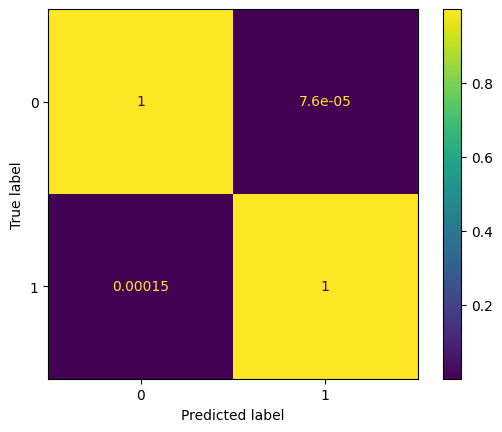

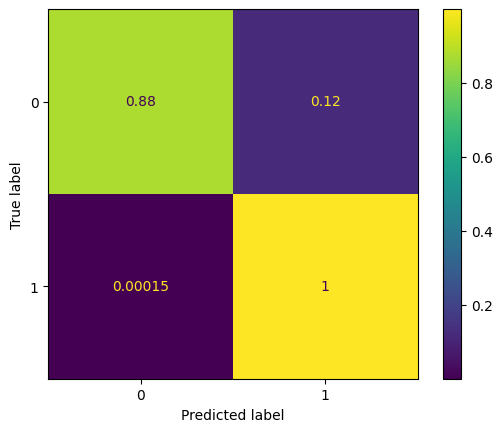

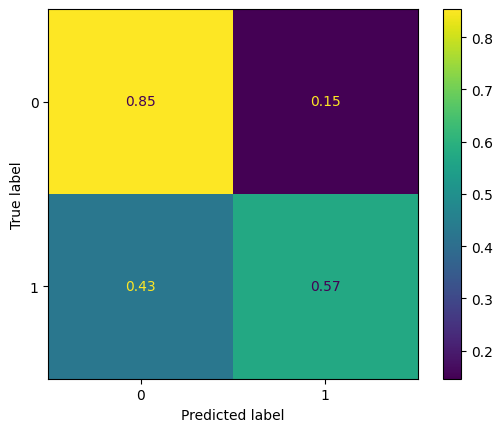

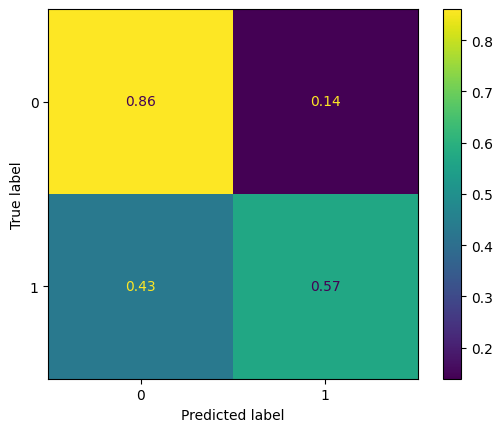

In [50]:
rf = RandomForestClassifier(random_state = 42)

rf.fit(X_rus, y_rus)
ConfusionMatrixDisplay(confusion_matrix(y_rus,rf.predict(X_rus),normalize='true')).plot()
ConfusionMatrixDisplay(confusion_matrix(y_train,rf.predict(X_trans),normalize='true')).plot()
ConfusionMatrixDisplay(confusion_matrix(y_val,rf.predict(X_val),normalize='true')).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test,rf.predict(X_test),normalize='true')).plot()


0    75761
1    75761
Name: Heart_Disease, dtype: int64 0    75761
1     6599
Name: Heart_Disease, dtype: int64


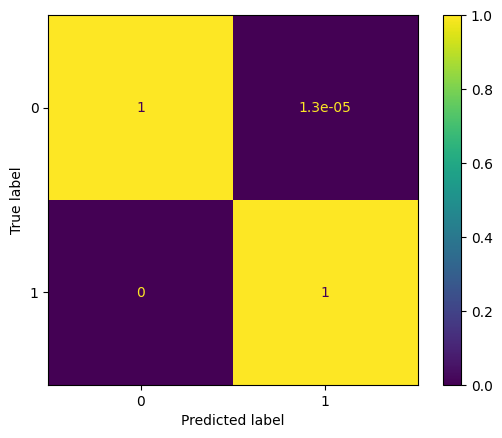

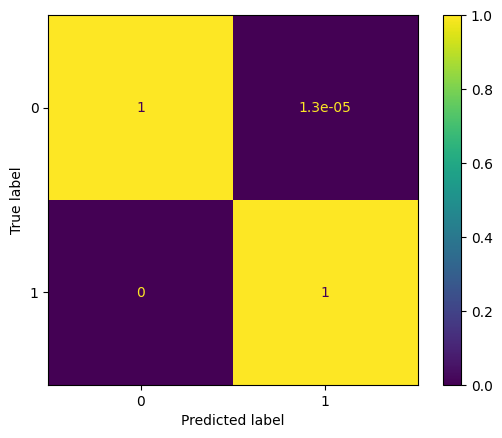

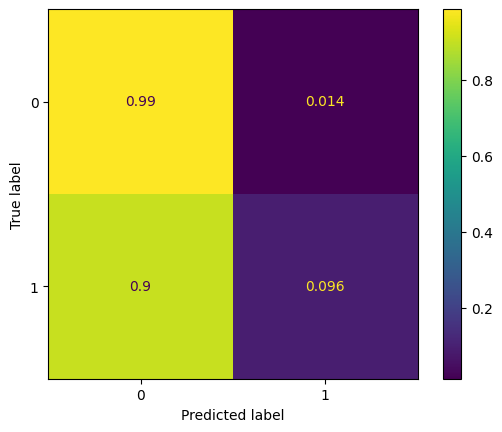

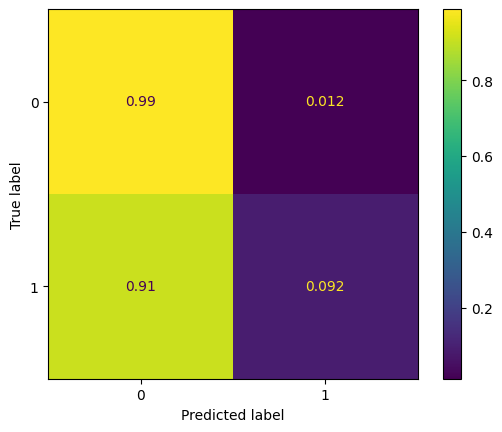

In [52]:
ros = RandomOverSampler(sampling_strategy = 0.5)
X_ros, y_ros = ros.fit_resample(X_trans,y_train)
print(y_ros.value_counts(), y_train.value_counts())
rf = RandomForestClassifier(random_state = 42)

rf.fit(X_ros, y_ros)
ConfusionMatrixDisplay(confusion_matrix(y_ros,rf.predict(X_ros),normalize='true')).plot()
ConfusionMatrixDisplay(confusion_matrix(y_train,rf.predict(X_trans),normalize='true')).plot()
ConfusionMatrixDisplay(confusion_matrix(y_val,rf.predict(X_val),normalize='true')).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test,rf.predict(X_test),normalize='true')).plot()

This is just a simple exploratory analysis. We constructed a bunch of models to get an intuition about the best strategies to put into production. This is, even if we dumped the RandomForest, we will only use the preprocessor ct 